<a href="https://colab.research.google.com/github/omer-re/wa_parser/blob/master/wa_parser_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# source/inspired by: https://www.imrankhan.dev/pages/Exploring%20WhatsApp%20chats%20with%20Python.html
import datetime

from dateutil.parser import parse
import pandas as pd
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import plotly.express as px

from google.colab import files
from google.colab import drive


In [4]:
def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try:
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

In [9]:
file = files.upload()
chat_file = f"/content/{list(file.keys())[0]}"
#chat_file='mob-ilai.txt'
#drive.mount('/mob-ilai.txt')

Mounted at /mob-ilai.txt


In [10]:
def parse_file(text_file):
    senders = []; messages = []; dates=[];times = []; timestamps=[]; directions=[];minutes=[];hours=[];

    word_list=['מעלית','חכו']
    f=open(chat_file,'r',encoding='utf8')
    lines=f.readlines()
    for i,line in enumerate(lines):
        if ('/' in line[:4]) and is_date(line.split('-',1)[0].split(',',1)[0]):
            date=line.split('-',1)[0].split(',',1)[0]
            try:
                time=line.split('-',1)[0].split(',',1)[1]
            except:
                print(line)
            sender_message=line.split('-',1)[1]
            separator=sender_message.find(':')
            if separator==(-1):
                continue
            timestamp= line.split('-',1)[0]
            sender=sender_message[:separator]
            message=sender_message[separator+1:]

            dates.append(date.strip())
            times.append(time.strip())
            #hr_mn=time.strip().split(':')
            mnt=time.strip().split(':')[1]
            minutes.append(int(mnt[:-3]))
            hour=time.strip().split(':')[0]
            if 'AM' in time or time.strip().startswith('0'):
                direction='morning'
            else:
                direction='evening'
                hour=int(hour)+12
            hours.append(int(hour))
            directions.append(direction)
            senders.append(sender)
            messages.append(message.replace('\n',''))
            timestamps.append(timestamp[:-1])


        else: # it is not a new message but new line of previous message
            new_msg=message+line
            messages[-1]=new_msg


    df = pd.DataFrame(zip(timestamps, dates, times,hours, minutes,directions, senders, messages), columns=['timestamps', 'date', 'time','hours','minutes','direction','sender', 'message'])
    df['timestamps'] = pd.to_datetime(df.timestamps, format='%m/%d/%y, %I:%M %p')
    df['time'] = pd.to_datetime(df.time, format='%I:%M %p').dt.time
    df['date'] = pd.to_datetime(df.date, format='%m/%d/%y').dt.date

    return df

In [28]:
from prettytable import PrettyTable
import tabulate
# source: https://www.stackvidhya.com/pretty-print-dataframe/
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

df = parse_file(chat_file)

df.set_index(df['timestamps'])
df.index=pd.to_datetime(df.index)
#print(df.head(20).to_markdown(index=False)) 


In [29]:
laters=df[df['message'].str.contains('לחכות|דקה|חכו|מעלית')]
#print(laters.to_markdown(index=False)) 

contain_words=df[df['message'].str.contains('לחכות|דקה|חכו|מעלית')]
contain_words2=df['message'].str.contains('לחכות|דקה|חכו|מעלית')

after_650=(df['hours']==6)       & (df['minutes']>50)
before_730=df[(df['hours']==7)   & (df['minutes']<30)]
# morning_range_7= (after_650 | before_730)

after_750=(df['hours']==7)       & (df['minutes']>50)
before_830=df[(df['hours']==8)   & (df['minutes']<30)]
# morning_range_8= (after_750 | before_830)

after_1650=df[(df['hours']==16)  & (df['minutes']>50)]
before_1710=df[(df['hours']==17) & (df['minutes']<10)]
# evening_range_17= (after_1650 | before_1710)


after_1750=df[(df['hours']==17)  & (df['minutes']>50)]
before_1810=df[(df['hours']==18) & (df['minutes']<10)]
# evening_range_18= (after_1750 | before_1810)


admins=['+972 50-201-2346', '+972 50-424-0266', '+972 50-571-4490', '+972 50-789-8030', '+972 52-854-5176', '+972 54-338-2794', '+972 54-658-1834']
#admins_mask = df['sender']==(lambda x: any(item for item in selection if item in admins))

laters=df[(df['message'].str.contains('לחכות|דקה|חכו|מעלית'))  &
          (
              ((df['hours']==6) & (df['minutes']>50)  | (df['hours']==7) & (df['minutes']<30))
            | ((df['hours']==7) & (df['minutes']>50)  | (df['hours']==8) & (df['minutes']<30))
            | ((df['hours']==16) & (df['minutes']>50) | (df['hours']==17) & (df['minutes']<10))
            | ((df['hours']==17) & (df['minutes']>50) | (df['hours']==18) & (df['minutes']<10))
          ) 
          ]

#print(laters.head(20).to_markdown(index=True))

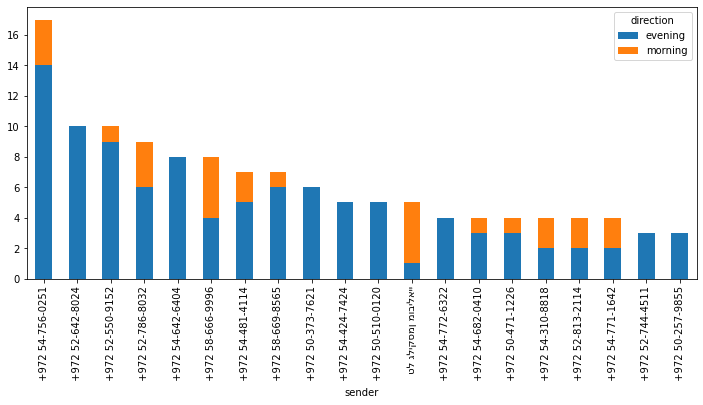

In [27]:
#laters3=laters[laters['message'].str.contains('לחכות|דקה|חכו|מעלית')]
#laters_fin = laters3[(laters2["minutes"]<10) | (laters2["minutes"] > 50)]
laters_group_by = laters.groupby(["sender", "direction"])['timestamps'].count().unstack()
laters_group_by = laters_group_by.fillna(0)
laters_group_by["sum"] = laters_group_by["evening"] + laters_group_by["morning"]
laters_group_by = laters_group_by.sort_values(by='sum', ascending=False)
graph= laters_group_by[["evening", "morning"]].head(20).plot.bar(figsize=(12,5),stacked=True)
